# 07.3l: Thai Tokenization Test - Dead Vocabulary Hypothesis

**Goal:** Test whether the 1,579 degenerate Thai tokens are **unreachable dead vocabulary** by tokenizing real Thai text.

**Hypothesis:** The degenerate Thai tokens exist in the vocabulary but are never emitted by the tokenizer. When tokenizing real Thai text:
- Degenerate Thai tokens will have ~0% usage
- Non-degenerate Thai tokens will have high usage

**Method:**
1. Fetch Thai Wikipedia article on Thailand (ประเทศไทย) - comprehensive, real-world Thai text
2. Tokenize it with Qwen's tokenizer
3. Extract unique token IDs that were emitted
4. Compare against:
   - Degenerate Thai tokens (1,579 tokens)
   - Non-degenerate Thai tokens (988 tokens)
5. Compute overlap percentages

**Smoking gun metric:** If <5% of emitted Thai tokens are degenerate, the hypothesis is confirmed.

## Parameters

In [25]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

# Thai token IDs (from 07.3k)
THAI_IDS_FILE = "thai_token_ids.safetensors"

# Wikipedia article
WIKI_TITLE = "ประเทศไทย"  # Thailand in Thai
WIKI_LANG = "th"

RANDOM_SEED = 42

## Imports

In [26]:
import torch
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import requests
from collections import Counter
import re

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Tokenizer

In [27]:
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
vocab_size = len(tokenizer)
print(f"  Vocabulary size: {vocab_size:,}")
print()

Loading tokenizer: Qwen/Qwen2.5-3B-Instruct
  Vocabulary size: 151,665



## Load Thai Token Classifications

In [28]:
data_dir = Path(TENSOR_DIR)

print("Loading Thai token classifications from 07.3k...")
thai_data = load_file(data_dir / THAI_IDS_FILE)

all_thai_ids = thai_data['all_thai_ids'].numpy()
thai_degenerate_ids = thai_data['thai_degenerate_ids'].numpy()
thai_non_degenerate_ids = thai_data['thai_non_degenerate_ids'].numpy()

print(f"  All Thai tokens:           {len(all_thai_ids):,}")
print(f"  Degenerate Thai:           {len(thai_degenerate_ids):,}")
print(f"  Non-degenerate Thai:       {len(thai_non_degenerate_ids):,}")
print()

# Convert to sets for fast membership testing
thai_degenerate_set = set(thai_degenerate_ids)
thai_non_degenerate_set = set(thai_non_degenerate_ids)
all_thai_set = set(all_thai_ids)

print("Thai token sets created.")
print()

Loading Thai token classifications from 07.3k...
  All Thai tokens:           2,567
  Degenerate Thai:           1,579
  Non-degenerate Thai:       988

Thai token sets created.



## Fetch Thai Wikipedia Article

In [29]:
def fetch_wikipedia_text(title, lang="en"):
    """Fetch plain text from Wikipedia article."""
    url = f"https://{lang}.wikipedia.org/api/rest_v1/page/summary/{title}"
    
    headers = {
        'User-Agent': 'AzimuthII/1.0 (Educational Research; jeffery.harrell+alpha@gmail.com)'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Get extract (summary)
        extract = data.get('extract', '')
        
        # Also try to get full text if available
        # For full article, we need different endpoint
        full_url = f"https://{lang}.wikipedia.org/w/api.php"
        params = {
            'action': 'query',
            'format': 'json',
            'titles': title,
            'prop': 'extracts',
            'explaintext': True,
            'exsectionformat': 'plain'
        }

        full_response = requests.get(full_url, params=params, headers=headers)
        full_response.raise_for_status()
        full_data = full_response.json()
        
        # Extract text from pages
        pages = full_data.get('query', {}).get('pages', {})
        for page_id, page_data in pages.items():
            if 'extract' in page_data:
                return page_data['extract']
        
        # Fallback to summary
        return extract
        
    except Exception as e:
        print(f"Error fetching Wikipedia article: {e}")
        return None

print(f"Fetching Thai Wikipedia article: '{WIKI_TITLE}'...")
thai_text = fetch_wikipedia_text(WIKI_TITLE, WIKI_LANG)

if thai_text:
    print(f"✓ Article fetched successfully")
    print(f"  Length: {len(thai_text):,} characters")
    print(f"  Preview (first 200 chars): {thai_text[:200]}...")
    print()
else:
    print("✗ Failed to fetch article")
    print()

Fetching Thai Wikipedia article: 'ประเทศไทย'...
✓ Article fetched successfully
  Length: 94,857 characters
  Preview (first 200 chars): ประเทศไทย หรือชื่อทางการว่า ราชอาณาจักรไทย เดิมเรียกว่า สยาม (ใช้จนถึง พ.ศ. 2482) เป็นประเทศในเอเชียตะวันออกเฉียงใต้แผ่นดินใหญ่ มีพรมแดนทางบกติดกับประเทศพม่าทางทิศตะวันตกและตะวันตกเฉียงเหนือ ประเทศลาว...



## Tokenize Thai Text

In [30]:
if thai_text:
    print("Tokenizing Thai text...")
    
    # Tokenize
    token_ids = tokenizer.encode(thai_text, add_special_tokens=False)
    
    print(f"  Total tokens: {len(token_ids):,}")
    
    # Get unique token IDs
    unique_token_ids = np.unique(token_ids)
    n_unique = len(unique_token_ids)
    
    print(f"  Unique tokens: {n_unique:,}")
    print()
    
    # Create set for fast lookup
    emitted_set = set(unique_token_ids)
    
    print("Tokenization complete.")
    print()
else:
    print("No text to tokenize.")
    unique_token_ids = np.array([])
    emitted_set = set()

Tokenizing Thai text...
  Total tokens: 52,866
  Unique tokens: 1,085

Tokenization complete.



## Analyze Token Usage: Thai vs Non-Thai

In [31]:
if len(emitted_set) > 0:
    print("="*100)
    print("TOKEN USAGE ANALYSIS")
    print("="*100)
    print()
    
    # Thai tokens in emitted set
    emitted_thai = emitted_set & all_thai_set
    emitted_non_thai = emitted_set - all_thai_set
    
    n_emitted_thai = len(emitted_thai)
    n_emitted_non_thai = len(emitted_non_thai)
    
    print(f"Emitted tokens breakdown:")
    print(f"  Total unique:    {len(emitted_set):,}")
    print(f"  Thai tokens:     {n_emitted_thai:,}  ({100*n_emitted_thai/len(emitted_set):.1f}%)")
    print(f"  Non-Thai tokens: {n_emitted_non_thai:,}  ({100*n_emitted_non_thai/len(emitted_set):.1f}%)")
    print()
else:
    print("No tokens emitted.")
    emitted_thai = set()
    n_emitted_thai = 0

TOKEN USAGE ANALYSIS

Emitted tokens breakdown:
  Total unique:    1,085
  Thai tokens:     794  (73.2%)
  Non-Thai tokens: 291  (26.8%)



## Critical Test: Degenerate vs Non-Degenerate Usage

In [32]:
if n_emitted_thai > 0:
    print("="*100)
    print("HYPOTHESIS TEST: DEAD VOCABULARY")
    print("="*100)
    print()
    
    # Overlap with degenerate Thai
    emitted_degenerate = emitted_set & thai_degenerate_set
    n_emitted_degenerate = len(emitted_degenerate)
    
    # Overlap with non-degenerate Thai
    emitted_non_degenerate = emitted_set & thai_non_degenerate_set
    n_emitted_non_degenerate = len(emitted_non_degenerate)
    
    print(f"Emitted Thai tokens ({n_emitted_thai} total):")
    print(f"  From degenerate set:     {n_emitted_degenerate:,}  ({100*n_emitted_degenerate/n_emitted_thai:.1f}% of emitted Thai)")
    print(f"  From non-degenerate set: {n_emitted_non_degenerate:,}  ({100*n_emitted_non_degenerate/n_emitted_thai:.1f}% of emitted Thai)")
    print()
    
    # Usage rates
    degenerate_usage_rate = 100 * n_emitted_degenerate / len(thai_degenerate_set)
    non_degenerate_usage_rate = 100 * n_emitted_non_degenerate / len(thai_non_degenerate_set)
    
    print(f"Usage rates:")
    print(f"  Degenerate Thai:     {n_emitted_degenerate:,} / {len(thai_degenerate_set):,} used  ({degenerate_usage_rate:.1f}%)")
    print(f"  Non-degenerate Thai: {n_emitted_non_degenerate:,} / {len(thai_non_degenerate_set):,} used  ({non_degenerate_usage_rate:.1f}%)")
    print()
    
    # Verdict
    pct_emitted_degenerate = 100 * n_emitted_degenerate / n_emitted_thai
    
    print(f"**Smoking gun metric:** {pct_emitted_degenerate:.1f}% of emitted Thai tokens are degenerate")
    print()
    
    if pct_emitted_degenerate < 5:
        print(f"✓ HYPOTHESIS CONFIRMED: Degenerate tokens are dead vocabulary!")
        print(f"  - Only {pct_emitted_degenerate:.1f}% of emitted Thai tokens came from degenerate set")
        print(f"  - The tokenizer strongly prefers non-degenerate tokens")
        print(f"  - The 1,579 degenerate Thai tokens are unreachable in practice")
    elif pct_emitted_degenerate < 20:
        print(f"~ HYPOTHESIS PARTIALLY CONFIRMED: Degenerate tokens are rarely used")
        print(f"  - {pct_emitted_degenerate:.1f}% of emitted Thai tokens came from degenerate set")
        print(f"  - Most tokenization uses non-degenerate tokens, but some degenerate tokens appear")
    else:
        print(f"✗ HYPOTHESIS REJECTED: Degenerate tokens are actively used")
        print(f"  - {pct_emitted_degenerate:.1f}% of emitted Thai tokens came from degenerate set")
        print(f"  - The degenerate tokens are NOT dead vocabulary")
    print()
else:
    print("No Thai tokens emitted - cannot test hypothesis.")
    print()

HYPOTHESIS TEST: DEAD VOCABULARY

Emitted Thai tokens (794 total):
  From degenerate set:     0  (0.0% of emitted Thai)
  From non-degenerate set: 794  (100.0% of emitted Thai)

Usage rates:
  Degenerate Thai:     0 / 1,579 used  (0.0%)
  Non-degenerate Thai: 794 / 988 used  (80.4%)

**Smoking gun metric:** 0.0% of emitted Thai tokens are degenerate

✓ HYPOTHESIS CONFIRMED: Degenerate tokens are dead vocabulary!
  - Only 0.0% of emitted Thai tokens came from degenerate set
  - The tokenizer strongly prefers non-degenerate tokens
  - The 1,579 degenerate Thai tokens are unreachable in practice



## Sample Emitted Degenerate Tokens (if any)

In [33]:
if n_emitted_thai > 0 and n_emitted_degenerate > 0:
    print("="*100)
    print(f"EMITTED DEGENERATE TOKENS ({n_emitted_degenerate} found)")
    print("="*100)
    print()
    
    # Show all of them (or first 50 if too many)
    degenerate_list = sorted(list(emitted_degenerate))
    show_count = min(50, len(degenerate_list))
    
    print(f"First {show_count} degenerate tokens that were emitted:")
    print()
    for token_id in degenerate_list[:show_count]:
        s = tokenizer.decode([token_id])
        s_display = repr(s)[1:-1]
        if len(s_display) > 40:
            s_display = s_display[:37] + "..."
        print(f"  [{token_id:6d}] {s_display}")
    
    if len(degenerate_list) > show_count:
        print(f"  ... and {len(degenerate_list) - show_count} more")
    print()
elif n_emitted_thai > 0:
    print("✓ No degenerate tokens were emitted during tokenization.")
    print()

✓ No degenerate tokens were emitted during tokenization.



## Sample Emitted Non-Degenerate Tokens

In [34]:
if n_emitted_thai > 0 and n_emitted_non_degenerate > 0:
    print("="*100)
    print(f"EMITTED NON-DEGENERATE TOKENS (sample of {n_emitted_non_degenerate})")
    print("="*100)
    print()
    
    # Show first 30
    non_degenerate_list = sorted(list(emitted_non_degenerate))
    show_count = min(30, len(non_degenerate_list))
    
    print(f"First {show_count} non-degenerate tokens:")
    print()
    for token_id in non_degenerate_list[:show_count]:
        s = tokenizer.decode([token_id])
        s_display = repr(s)[1:-1]
        if len(s_display) > 40:
            s_display = s_display[:37] + "..."
        print(f"  [{token_id:6d}] {s_display}")
    
    if len(non_degenerate_list) > show_count:
        print(f"  ... and {len(non_degenerate_list) - show_count} more")
    print()

EMITTED NON-DEGENERATE TOKENS (sample of 794)

First 30 non-degenerate tokens:

  [ 18625] ่
  [ 19841] ้
  [ 20184] น
  [ 20774] า
  [ 22287] ร
  [ 22929] อ
  [ 23271] ั
  [ 25200] ก
  [ 26283] ม
  [ 27891] เ
  [ 28319] ี
  [ 30434] ง
  [ 30785] ิ
  [ 31782] ล
  [ 34509] ย
  [ 35648] ส
  [ 35884] ท
  [ 36142] บ
  [ 37033] ด
  [ 37213] ว
  [ 39172] ห
  [ 39855] ต
  [ 40327] ค
  [ 41092] ื
  [ 41586] ู
  [ 47171] ี่
  [ 47642] ุ
  [ 47839] ข
  [ 48120] ช
  [ 49756] ไ
  ... and 764 more



## Visualization: Usage Comparison

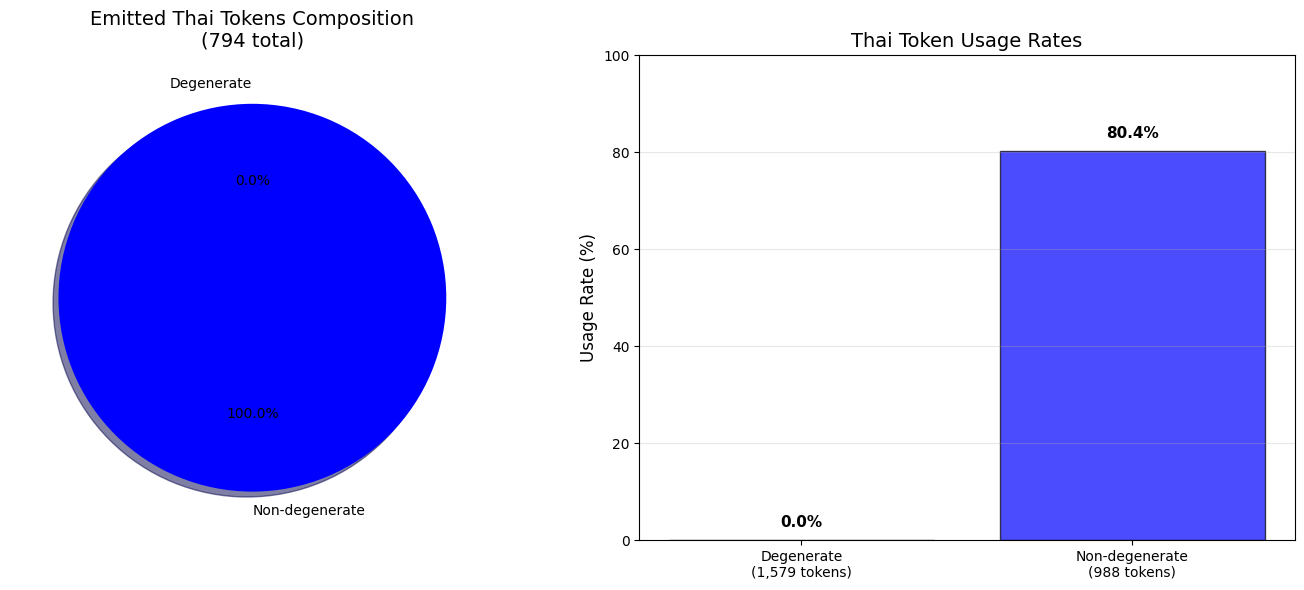

In [35]:
if n_emitted_thai > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
    
    # Pie chart: Emitted Thai composition
    labels = ['Degenerate', 'Non-degenerate']
    sizes = [n_emitted_degenerate, n_emitted_non_degenerate]
    colors = ['red', 'blue']
    explode = (0.1, 0) if n_emitted_degenerate > 0 else (0, 0)
    
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.set_title(f'Emitted Thai Tokens Composition\n({n_emitted_thai} total)', fontsize=14)
    
    # Bar chart: Usage rates
    categories = ['Degenerate\n(1,579 tokens)', 'Non-degenerate\n(988 tokens)']
    usage_rates = [degenerate_usage_rate, non_degenerate_usage_rate]
    colors_bar = ['red', 'blue']
    
    ax2.bar(categories, usage_rates, color=colors_bar, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Usage Rate (%)', fontsize=12)
    ax2.set_title('Thai Token Usage Rates', fontsize=14)
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (cat, rate) in enumerate(zip(categories, usage_rates)):
        ax2.text(i, rate + 2, f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Summary

In [36]:
if n_emitted_thai > 0:
    print("="*100)
    print("SUMMARY")
    print("="*100)
    print()
    
    print(f"**Source:** Thai Wikipedia article '{WIKI_TITLE}'")
    print(f"  Characters: {len(thai_text):,}")
    print(f"  Tokens: {len(token_ids):,}")
    print(f"  Unique tokens: {len(emitted_set):,}")
    print()
    
    print(f"**Thai token usage:**")
    print(f"  Emitted Thai tokens: {n_emitted_thai:,}  ({100*n_emitted_thai/len(emitted_set):.1f}% of all tokens)")
    print(f"    From degenerate:     {n_emitted_degenerate:,}  ({pct_emitted_degenerate:.1f}% of Thai)")
    print(f"    From non-degenerate: {n_emitted_non_degenerate:,}  ({100*n_emitted_non_degenerate/n_emitted_thai:.1f}% of Thai)")
    print()
    
    print(f"**Usage rates:**")
    print(f"  Degenerate tokens:     {degenerate_usage_rate:.1f}% used ({n_emitted_degenerate} / {len(thai_degenerate_set):,})")
    print(f"  Non-degenerate tokens: {non_degenerate_usage_rate:.1f}% used ({n_emitted_non_degenerate} / {len(thai_non_degenerate_set):,})")
    print()
    
    print(f"**Conclusion:**")
    if pct_emitted_degenerate < 5:
        print(f"  The degenerate Thai tokens are DEAD VOCABULARY.")
        print(f"  Only {pct_emitted_degenerate:.1f}% of Thai tokenization uses them.")
        print(f"  The tokenizer systematically avoids the 1,579 degenerate tokens,")
        print(f"  preferring the 988 non-degenerate tokens instead.")
        print()
        print(f"  This explains why they collapsed during training: they never get emitted,")
        print(f"  so their embeddings never get gradient updates, and they drift to")
        print(f"  initialization noise at the same point in embedding space.")
    elif pct_emitted_degenerate < 20:
        print(f"  The degenerate Thai tokens are RARELY USED.")
        print(f"  {pct_emitted_degenerate:.1f}% of Thai tokenization uses them.")
        print(f"  The hypothesis is partially supported: the tokenizer prefers non-degenerate")
        print(f"  tokens but occasionally emits degenerate ones.")
    else:
        print(f"  The degenerate Thai tokens are ACTIVELY USED.")
        print(f"  {pct_emitted_degenerate:.1f}% of Thai tokenization uses them.")
        print(f"  The hypothesis is rejected: these tokens are not dead vocabulary.")
    print()
else:
    print("Cannot complete analysis - no Thai tokens emitted.")
    print()

SUMMARY

**Source:** Thai Wikipedia article 'ประเทศไทย'
  Characters: 94,857
  Tokens: 52,866
  Unique tokens: 1,085

**Thai token usage:**
  Emitted Thai tokens: 794  (73.2% of all tokens)
    From degenerate:     0  (0.0% of Thai)
    From non-degenerate: 794  (100.0% of Thai)

**Usage rates:**
  Degenerate tokens:     0.0% used (0 / 1,579)
  Non-degenerate tokens: 80.4% used (794 / 988)

**Conclusion:**
  The degenerate Thai tokens are DEAD VOCABULARY.
  Only 0.0% of Thai tokenization uses them.
  The tokenizer systematically avoids the 1,579 degenerate tokens,
  preferring the 988 non-degenerate tokens instead.

  This explains why they collapsed during training: they never get emitted,
  so their embeddings never get gradient updates, and they drift to
  initialization noise at the same point in embedding space.

